# Wave Equation

This notebook implements the PIGP and PSGP experiments involving the wave equation from Section 4.4 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = False

if not USE_GPU:
    os.environ["JAX_PLATFORM_NAME"] = "cpu"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [27]:
import jax.numpy as jnp
from jax import config, random

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append("../../")

import jax_pigp
from jax_pigp.utility_fns import (
    softplus,
    generate_params,
    PARAM_OPTIONS_DICT as param_gen_options,
)
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True)

### Specify settings of the experiments

Ensure that this cell is tagged as "parameters" if using [papermill](https://papermill.readthedocs.io/en/latest/)

In [3]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 444

# whether to use a psgp or pigp, i.e. whether to incorporate symmetry information
# into the inference or not
GP_TYPE = "psgp"
assert GP_TYPE in ["pigp", "psgp"]

# number of points in u/f/g space to consider. Note: in this example we
# can satisfy the symmetry exactly by operating on the system of canonical
# coordinates, and therefore no psuedo-observations of the ISC are required,
# i.e. Ng = 0
Nu: int = 64
Nf: int = 500

# path to subdirectory in ./data where fisher-like equation data is saved
data_save_dir: str = f"waveEquation"
data_save_dir_full = os.path.join("data", data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# in this example we incorporate symmetry information by operating on the
# canonical coordinate system, which means that we automatically satisfy
# the PDE, therefore no psuedo-observations of the PDE are required (i.e.
# Nf=0), and also this reduces the dimensionality of the input space to 1
if GP_TYPE == "psgp":
    Nf = 0
    INPUT_DIM = 1

# initial value for std of noise levels in each space
NOISE_INIT: float = 0.1

# softplus transformation ensures noise values are positive
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = False

# options for model training
N_TRAIN_STEPS: int = 25000
N_RESTARTS: int = 3
LR_INIT: float = 0.005
VERBOSE: bool = False

### Specify mean and kernel functions

In [4]:
base_kernel = jax_pigp.kernels.rational_quadratic

# if using PSGP model, we implement kernel function on
# canonical coordinate system to explicitly enforce the
# ISC (and PDE)
if GP_TYPE == "psgp":

    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        # convert to canonical coordinates
        z1 = loc1[0:1] - loc1[1:]
        z2 = loc2[0:1] - loc2[1:]

        return base_kernel(params, z1, z2)

else:
    kernel_fn = base_kernel

mean_fn = jax_pigp.mean_functions.zero_mean_fn

### Specify linear differential operators

Recall that the wave PDE over one spatial dimension takes the form

$$PDE[u]  = \frac{\partial^2 u}{\partial t^2} - \frac{\partial^2 u}{\partial x^2} = f = 0,$$

or, in shorthand notation (see Eq.(28) of the paper):

$$PDE[u] = u_{tt} - u_{xx} = f = 0.$$

##### Implementation: 

* We define a dummy linear operator for solution-space (i.e. $u$-space) data which is just the identity transformation
* The wave PDE can be applied to a given input function by calling ``apply_PDE`` as defined below
* The Wave ISC (see Eq.(30) of the paper) does not need to be implemented as it can be explicitly enforced by operating on the canonical coordinate system

In [5]:
def apply_Identity(fn: Callable, argnum: int = 1):
    r"""
    Dummy identity transformation for u-space data
    """
    return fn


def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the Wave PDE to given input
    fn, evaluated at specified argnum
    """

    # the Hessian function
    _, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal
        ## value in loc1 / loc2

        uxx_val, utt_val = jnp.diag(Hfn(params, loc1, *loc2))

        return utt_val - uxx_val

    return PDE


linear_operators = [apply_Identity, apply_PDE]

### Store settings

Store optimisation options in a dictionary

In [6]:
opt_options = {}
opt_options["n_steps"] = N_TRAIN_STEPS
opt_options["n_restarts"] = N_RESTARTS
opt_options["lr"] = LR_INIT
opt_options["verbose"] = VERBOSE
opt_options["noise_transform"] = NOISE_TRANSFORM

Specify parameter initialisation function

In [7]:
param_gen_options["input_dim"] = INPUT_DIM
# each function space gets its own noise level
param_gen_options["noise_std_init"] = [NOISE_INIT]*len(linear_operators)
param_gen_options["noise_transform"] = NOISE_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [8]:
results_save_dir = os.path.join("results", data_save_dir + f"{GP_TYPE}_Nu_{Nu}")
if not os.path.isdir(results_save_dir):
    os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [9]:
train_data, test_data = load_data(data_save_dir_full, Nu, Nf)

Check shapes of train and test data

In [10]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((64, 1), (8000, 1), [(64, 2), (0, 2)])

### Initialise PIGP model

In [11]:
wave_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(
    kernel_fn, linear_operators
)
wave_mean_fns = jax_pigp.interdomain_moments.InterdomainMeanFns(
    mean_fn, linear_operators
)

gp_model = jax_pigp.models.GPR(wave_kernel_fns, wave_mean_fns)

### Initialise learner for model training

In [12]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)

gp_learner = jax_pigp.optimisers.AdamLearner(
    obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL)
)

Initial parameter values  

In [13]:
print_param_values(gp_learner.params, opt_options)

amp: [11.12904922]
ls: [4.85472364]
alpha: [20.70434987]
noise_std: [0.1 0.1]


Objective function value for initial parameters

In [14]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(5.31254237, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [15]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(-5.31254237, dtype=float64),
 {'alpha': Array([0.74152475], dtype=float64),
  'amp': Array([-2.80592557], dtype=float64),
  'ls': Array([71.5624615], dtype=float64),
  'noise_std': Array([6.93216644, 0.        ], dtype=float64)})

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [16]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [17]:
print(
    f"gp_type={GP_TYPE}, with Nu={Nu}, Nf={Nf}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n"
)
gp_learner.train_with_restarts(
    opt_options["n_steps"],
    opt_options["n_restarts"],
    print_progress=opt_options["verbose"],
)

gp_type=psgp, with Nu=64, Nf=0, n_steps=25000, n_restarts=3

Restart 0: beginning training for 25000 steps
Final training results: 
(24999): -52.4505, noise_std_vals = [6.63e-02,1.00e-01]


Restart 1: beginning training for 25000 steps
Final training results: 
(24999): -52.4533, noise_std_vals = [6.63e-02,1.00e-01]


Restart 2: beginning training for 25000 steps
Final training results: 
(24999): -52.4651, noise_std_vals = [6.63e-02,1.00e-01]




Uncomment below to continue training from existing parameter values:

In [18]:
# gp_learner.train(opt_options["n_steps"])

### Plot training results

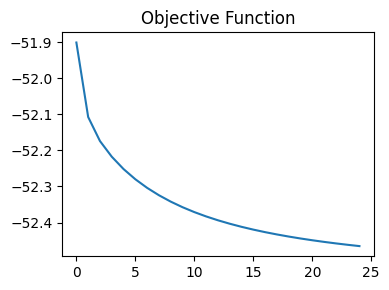

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list) * 0.05)

plot_lc(ax, gp_learner.obj_list[begin_at:], "Objective Function")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "learningCurves.pdf"))

### Final trained parameter values

In [20]:
# extract final trained parameter values
try:
    trained_params = gp_learner.params_best.copy()
    print(f'set trained_params to gp_learner.params_best\n')
except:
    trained_params = gp_learner.params.copy()
    print(f'set trained_params to gp_learner.params\n')

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
param_save_path = os.path.join(results_save_dir, "trained_params.pkl")
with open(param_save_path, "wb") as fp:
    pickle.dump(trained_params, fp)

set trained_params to gp_learner.params_best

alpha: [119.83775668]
amp: [2.63179913]
ls: [2.7667787]
noise_std: [0.06630704 0.1       ]


Can load pre-trained parameters by uncommenting the below

In [21]:
# with open(param_save_path, 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [22]:
# posterior mean and covariance over test points
print(
    f"Posterior results for {GP_TYPE}, with Nu={Nu}, Nf={Nf}, Ns={test_data.Xs.shape[0]}"
)
# posterior mean and covariance over test outputs us
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)

# standard deviation of prediction at each test point
s = jnp.diag(Sigma) ** 0.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, "u_pred.npy"), mu)
    jnp.save(os.path.join(results_save_dir, "s_pred.npy"), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f"mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}")
savetxt(
    os.path.join(results_save_dir, "mean_loss.txt"), abs_losses.mean().reshape(-1, 1)
)

Posterior results for psgp, with Nu=64, Nf=0, Ns=8000
mean/max loss: 3.950030e-02/9.567e-01


### Plots of posterior prediction

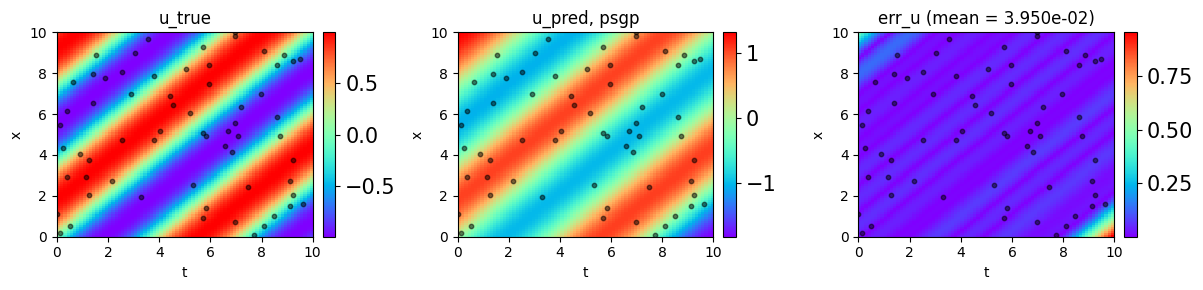

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=THREE_COLUMN_FIGSIZE)

Nx = len(jnp.unique(test_data.Xs[:, 0]))
Nt = len(jnp.unique(test_data.Xs[:, 1]))

Xu, Xf = train_data.Xtrain

make_heatmap_wave = lambda ax, output, title=None: make_heatmap(
    fig, ax, output.reshape(Nt, Nx).T, test_data, Xu, Xf, title
)

make_heatmap_wave(axes[0], test_data.us, title="u_true")
make_heatmap_wave(axes[1], mu, title=f"u_pred, {GP_TYPE}")
make_heatmap_wave(axes[2], abs_losses, title=f"err_u (mean = {abs_losses.mean():.3e})")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "posteriorPrediction.pdf"))